In [22]:
%run globals
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd
# produce matlab-style plots
import matplotlib as mpl
import pickle
import os
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import scipy

# increase font size on plots
fontsize=15
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : fontsize}
matplotlib.rc('font', **font)
# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 15})
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

## unpack feedback controllers

each B has 11 participants and 8 stimulated frequencies

In [2]:
# load EMG 1st order feedback controllers
f = open("LNP_FB_1st_emg.pickle","rb")
B_fo_emg = pickle.load(f,encoding='latin1')
f.close()

# load manual 1st order feedback controllers
f = open("LNP_FB_1st_man.pickle","rb")
B_fo_man = pickle.load(f,encoding='latin1')
f.close()

# load EMG 2nd order feedback controllers
f = open("LNP_FB_2nd_emg.pickle","rb")
B_so_emg = pickle.load(f,encoding='latin1')
f.close()

# load manual 2nd order feedback controllers
f = open("LNP_FB_2nd_man.pickle","rb")
B_so_man = pickle.load(f,encoding='latin1')
f.close()

In [3]:
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19])# max =37
soIX = primes*2
base = 20


freqs = primes/base
omegas = freqs*np.pi*2
s = 1j*omegas
xlim = (freqs[0]-.01,freqs[-1]+.1)
#xlim = (1.5/base,21.0/base)
Mfo = lambda s: 1/s
Mso = lambda s: 1/(s*(s+1))
s = 1j*omegas
phaseshift = np.pi/2

yticksmag = [1e-1,1e0,1e+1]

ylimphase = (-1.1*np.pi,+1.1*np.pi)
yticksphase = [-np.pi,-np.pi/2,0.,np.pi/2,np.pi]
yticklabelsphase = [r'$-\frac{3\pi}{2}$',r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$+\frac{\pi}{2}$',r'$+\pi$']
yticksphase = [-np.pi-np.pi/2,-np.pi,-np.pi/2,0.,np.pi/2,np.pi]
# yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']

lw = 1
markersize = 30
elinewidth = 2
linestyles = dict(F='-',B='-')

def bode_plot(data=None,fname=None,axs=None,color='k',fill=None,amean=0.,grid='on',ls='-',label=None,do_ylabels=False,title=None):
    if data is None:
        data = np.nan*freqs*np.zeros((3,1))
    
    if fill is None:
        fill = list(mpl.colors.to_rgba(color))
        fill[-1] = 0.5

    if axs is None:
        fig,axs = plt.subplots(2,1,sharex=True, figsize=(6,4))
        
    for ax in axs:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xscale("log")
    
    axm,axp = axs
    axm.set_yscale("log") 
    
    # magnitude
    d25,d50,d75 = np.percentile(np.abs(data),[25,50,75],axis=0)
    axm.fill_between(freqs,d25,d75,facecolor=fill,edgecolor='k',lw=lw)
    axm.plot(freqs,d50,color=color,lw=2*lw,zorder=1,ls=ls)
    #ax.plot(xlim,[1.,1.],'k--',zorder=-1)

    axm.set_xlim(xlim)
    axm.set_xticks([])
    axm.set_xticklabels([])
    
    axm.set_ylim((yticksmag[0],yticksmag[-1]))
    axm.set_yticks(yticksmag)
    axm.tick_params(axis='x',labelsize=fontsize)
    axm.tick_params(axis='y',labelsize=fontsize)
    if do_ylabels:
        axm.set_yticklabels(axm.get_yticks(), **font)
        axm.set_ylabel('gain',fontsize=fontsize)
    else:
        axm.set_yticklabels([])
    
    axm.grid(grid)
    
    # phase
    temp = np.angle(data)+phaseshift# np.unwrap(np.angle(data)*2)/2
    a = np.mod(temp+(amean-np.pi),2*np.pi)-(amean+np.pi) - phaseshift
#     a = np.mod(np.angle(data)+(amean-np.pi),2*np.pi)-(amean+np.pi)
    d25,d50,d75 = np.percentile(a,[25,50,75],axis=0)
    axp.fill_between(freqs,d25,d75,facecolor=fill,edgecolor='k',lw=lw,label=label)
    axp.plot(freqs,d50,color=color,lw=2*lw,zorder=1,ls=ls)

    axp.set_xlim(xlim)
    axp.set_xticks(freqs[:-1])
    axp.set_xticklabels(freqs[:-1],rotation=90)
    axp.set_xlabel('frequency (Hz)',fontsize=fontsize)
    
    axp.set_ylim((yticksphase[0],yticksphase[2]))
    axp.set_yticks(yticksphase[:3])
    if do_ylabels:
        axp.set_yticklabels(yticklabelsphase[:3], **font)
        axp.set_ylabel('phase (radians)',fontsize=fontsize)
    else:
        axp.set_yticklabels([])
    axp.tick_params(axis='x',labelsize=fontsize)
    axp.tick_params(axis='y',labelsize=fontsize)
    axp.grid(grid)

    axp.legend(loc='lower center',ncol=4)
    
    if title is not None:
        axm.set_title(title)
    
    plt.tight_layout()
    
#     if fname is not None:
#         fig = plt.gcf()
#         for fmt in fmts:
#             if not(os.path.exists(fmt)): os.mkdir(fmt)
#             fig.savefig(os.path.join(fmt,fname+'.'+fmt),bbox_inches='tight',pad_inches=0)
    
    return axs


# plot open loop transfer function

In [4]:
# load H estimates
f = open("emg_est","rb")
H_emg = pickle.load(f,encoding='latin1')
f.close()

f = open("man_est","rb")
H_man = pickle.load(f,encoding='latin1')
f.close()

# order k1, tau1, k2, tau2 for both
H_emg.shape,H_man

((4, 2),
 array([[2.08186662, 2.75535834],
        [0.28766559, 0.34059457],
        [1.53806937, 3.96714907],
        [0.2329401 , 0.4088054 ]]))

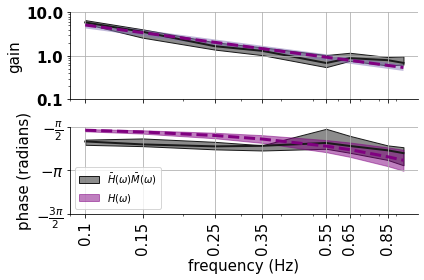

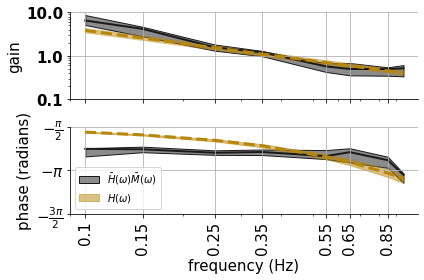

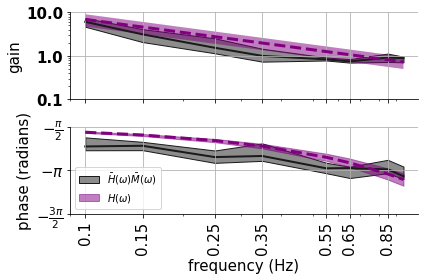

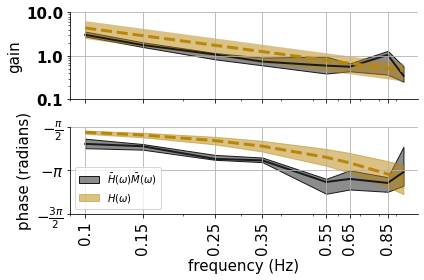

In [11]:
B_label=r'$H(\omega)$'
data_label = r'$\bar{H}(\omega)\bar{M}(\omega)$'
color_man = 'darkgoldenrod'
color_emg = 'purple'
alpha = 0.5

axs = bode_plot(data=(B_fo_emg*Mfo(s)),fname='EMG_fo', do_ylabels=True,label=data_label)
axm,axp = axs
# plot fit B
axm.fill_between(freqs,abs(H_emg[0,0]/s),abs(H_emg[0,1]/s),facecolor='m',alpha=alpha)
axm.plot(freqs,abs(np.mean(H_emg[0])/s),color=color_emg,linestyle='--',linewidth=3)
axp.plot(freqs,np.unwrap(phaseshift+np.angle(np.exp(-s*np.mean(H_emg[1]))/s))-phaseshift,color=color_emg,linestyle='--',linewidth=3)
axp.fill_between(freqs,np.unwrap(phaseshift+np.angle(np.exp(-s*H_emg[1,0])/s))-phaseshift,np.unwrap(phaseshift+np.angle(np.exp(-s*H_emg[1,1])/s))-phaseshift,edgecolor=color_emg,lw=lw,facecolor=color_emg,alpha=alpha,label=B_label)
plt.legend(loc='lower left')
fname='EMG_fo'
if fname is not None:
    fig = plt.gcf()
    for fmt in fmts:
        if not(os.path.exists(fmt)): os.mkdir(fmt)
        fig.savefig(os.path.join(fmt,fname+'.'+fmt),bbox_inches='tight',pad_inches=0)

axs = bode_plot(data=(B_fo_man*Mfo(s)),fname='manual_fo', do_ylabels=True,label=data_label)
axm,axp = axs
# plot fit B
axm.fill_between(freqs,abs(H_man[0,0]/s),abs(H_man[0,1]/s),facecolor=color_man,alpha=alpha)
axm.plot(freqs,abs(np.mean(H_man[0])/s),color=color_man,linestyle='--',linewidth=3)
axp.plot(freqs,np.unwrap(phaseshift+np.angle(np.exp(-s*np.mean(H_man[1]))/s))-phaseshift,color=color_man,linestyle='--',linewidth=3)
axp.fill_between(freqs,np.unwrap(phaseshift+np.angle(np.exp(-s*H_man[1,0])/s))-phaseshift,np.unwrap(phaseshift+np.angle(np.exp(-s*H_man[1,1])/s))-phaseshift,edgecolor=color_man,lw=lw,facecolor=color_man,alpha=alpha,label=B_label)
plt.legend(loc='lower left')
fname='manual_fo'
if fname is not None:
    fig = plt.gcf()
    for fmt in fmts:
        if not(os.path.exists(fmt)): os.mkdir(fmt)
        fig.savefig(os.path.join(fmt,fname+'.'+fmt),bbox_inches='tight',pad_inches=0)

axs = bode_plot(data=(B_so_emg*Mso(s)),fname='EMG_so', do_ylabels=True,label=data_label)
axm,axp = axs
axm.fill_between(freqs,abs(H_emg[2,0]/s),abs(H_emg[2,1]/s),facecolor=color_emg,alpha=alpha)
axm.plot(freqs,abs(np.mean(H_emg[2])/s),color=color_emg,linestyle='--',linewidth=3)
axp.plot(freqs,np.unwrap(phaseshift+np.angle(np.exp(-s*np.mean(H_emg[3]))/s))-phaseshift,color=color_emg,linestyle='--',linewidth=3)
axp.fill_between(freqs,np.unwrap(phaseshift+np.angle(np.exp(-s*H_emg[3,0])/s))-phaseshift,np.unwrap(phaseshift+np.angle(np.exp(-s*H_emg[3,1])/s))-phaseshift,edgecolor=color_emg,lw=lw,facecolor=color_emg,alpha=alpha,label=B_label)
plt.legend(loc='lower left')
fname='EMG_so'
if fname is not None:
    fig = plt.gcf()
    for fmt in fmts:
        if not(os.path.exists(fmt)): os.mkdir(fmt)
        fig.savefig(os.path.join(fmt,fname+'.'+fmt),bbox_inches='tight',pad_inches=0)

axs = bode_plot(data=(B_so_man*Mso(s)),fname='manual_so', do_ylabels=True,label=data_label)
axm,axp = axs
axm.fill_between(freqs,abs(H_man[2,0]/s),abs(H_man[2,1]/s),facecolor=color_man,alpha=alpha)
axm.plot(freqs,abs(np.mean(H_man[2])/s),color=color_man,linestyle='--',linewidth=3)
axp.plot(freqs,np.unwrap(phaseshift+np.angle(np.exp(-s*np.mean(H_man[3]))/s))-phaseshift,color=color_man,linestyle='--',linewidth=3)
axp.fill_between(freqs,np.unwrap(phaseshift+np.angle(np.exp(-s*H_man[3,0] )/s))-phaseshift,np.unwrap(phaseshift+np.angle(np.exp(-s*H_man[3,1])/s))-phaseshift,edgecolor=color_man,lw=lw,facecolor=color_man,alpha=alpha,label=B_label)
plt.legend(loc='lower left')

fname='manual_so'
if fname is not None:
    fig = plt.gcf()
    for fmt in fmts:
        if not(os.path.exists(fmt)): os.mkdir(fmt)
        fig.savefig(os.path.join(fmt,fname+'.'+fmt),bbox_inches='tight',pad_inches=0)

plt.show()

## plot just the delays

In [32]:
# compare manual vs EMG 
manvsEMGfo = scipy.stats.ttest_ind_from_stats(np.mean(H_man[1]),(H_man[1,1]-H_man[1,0])/3.92*np.sqrt(11),11,
                                                                            np.mean(H_emg[1]),(H_emg[1,1]-H_emg[1,0])/3.92*np.sqrt(11),11)
print('manual vs EMG first order:', manvsEMGfo.pvalue)

manvsEMGso = scipy.stats.ttest_ind_from_stats(np.mean(H_man[3]),(H_man[3,1]-H_man[3,0])/3.92*np.sqrt(11),11,
                                                                            np.mean(H_emg[3]),(H_emg[3,1]-H_emg[3,0])/3.92*np.sqrt(11),11)
print('manual vs EMG second order:', manvsEMGso.pvalue)

# compare first vs second order
fovssoEMG = scipy.stats.ttest_ind_from_stats(np.mean(H_emg[1]),(H_emg[1,1]-H_emg[1,0])/3.92*np.sqrt(11),11,
                                                                            np.mean(H_emg[3]),(H_emg[3,1]-H_emg[3,0])/3.92*np.sqrt(11),11)
print('fo vs so EMG:', fovssoEMG.pvalue)

fovssoman = scipy.stats.ttest_ind_from_stats(np.mean(H_man[1]),(H_man[1,1]-H_man[1,0])/3.92*np.sqrt(11),11,
                                                                            np.mean(H_man[3]),(H_man[3,1]-H_man[3,0])/3.92*np.sqrt(11),11)
print('fo vs so manual:', fovssoman.pvalue)

manual vs EMG first order: 0.005049086040944307
manual vs EMG second order: 0.9895208031112886
fo vs so EMG: 0.005703206097251679
fo vs so manual: 0.887007011838566


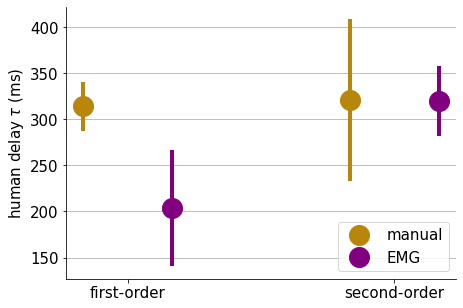

In [13]:
fig,ax = plt.subplots(figsize=(7,5))
xx = [0.95,1.05,1.25,1.35]
xticklabels = ['first-order','second-order']

ax.errorbar(xx[0],1000*np.mean(H_man[1]),yerr=1000*H_man[1,0]-1000*np.mean(H_man[1]),fmt='o',markersize=markersize,linewidth=4,color=color_man,label='manual')
ax.errorbar(xx[1],1000*np.mean(H_emg[1]),yerr=1000*H_emg[1,0]-1000*np.mean(H_emg[1]),fmt='o',markersize=markersize,linewidth=4,color=color_emg,label='EMG')
ax.errorbar(xx[2],1000*np.mean(H_man[3]),yerr=1000*H_man[3,0]-1000*np.mean(H_man[3]),fmt='o',markersize=markersize,linewidth=4,color=color_man)
ax.errorbar(xx[3],1000*np.mean(H_emg[3]),yerr=1000*H_emg[3,0]-1000*np.mean(H_emg[3]),fmt='o',markersize=markersize,linewidth=4,color=color_emg)
ax.set_xticks([np.mean(xx[:2]),np.mean(xx[2:])])
ax.set_xticklabels(xticklabels,fontsize=fontsize)
ax.set_ylabel(r'human delay $\tau$ (ms)',fontsize=fontsize)
ax.tick_params(axis='x',labelsize=fontsize)
ax.tick_params(axis='y',labelsize=fontsize)
plt.legend(loc='lower right',fontsize=fontsize)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y')
# plt.show()

fname = 'EMGdelay_varsplot'
if fname is not None:
    fig = plt.gcf()
if not(os.path.exists('pdf')): 
    os.mkdir('pdf')
fig.savefig(os.path.join('pdf',fname+'.'+'pdf'),bbox_inches='tight',pad_inches=0)

NameError: name 'CB_color_cycle' is not defined

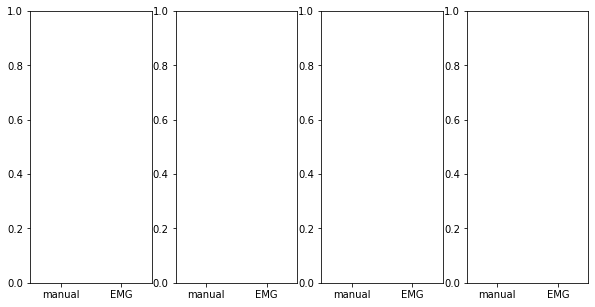

In [8]:
# PLOT DELAY
# CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
#                   '#f781bf', '#a65628', '#984ea3',
#                   '#999999', '#e41a1c', '#dede00']
markersize = 20
titles=['visual delay','feedback delay','visual gain', 'feedback gain']
yaxis = ['time (ms)','time (ms)','gain','gain']
data = [H_man[1],H_man[3],H_emg[1],H_emg[3]]
xx = np.arange(1,3,1)
# plt.errorbar(xx,np.hstack([vis_delay[:,1],fb_delay[:,1]]),
#              np.hstack([vis_delay[:,1]-vis_delay[:,0],fb_delay[:,1]-fb_delay[:,0]]), 
#              linestyle='None', marker='^')
fig,axs = plt.subplots(1,4,sharex=True,sharey=False,figsize=(10,5))
plt.setp(axs, xticks=[1,2], xticklabels=['manual','EMG'])
plt.xlim((0.5,2.5))
# plot visual delay
for ix,ax in enumerate(axs):
    ax.errorbar(xx[0],np.mean(data[ix]),yerr=data[ix][0]-data[ix][0], 
                 fmt='o',markersize=markersize,linewidth=4,color=CB_color_cycle[6])
    ax.errorbar(xx[1],data[ix][:,1][1],yerr=data[ix][:,1][1]-data[ix][:,0][1], 
                 fmt='o',markersize=markersize,linewidth=4,color=CB_color_cycle[5])
    ax.set_title(titles[ix])
#     if ix == 0 or ix == 2:
    ax.set_ylabel(yaxis[ix])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
# # plot pvalue 
# y1 = .25243*1000
# pos1 = 1
# pos2 = 2
# linewidth = 2
# axs[0].plot([pos1,pos1,pos2,pos2],[y1,y1+.03,y1+.03,y1],lw=1.5,c='k')
# # axs[0].plot([pos1,pos1,pos2,pos2],[y1,y1,y1,y1],lw=1.5,c='k')
# axs[0].text((pos1+pos2)*.5,y1+.03,r'$p=0.45$',ha='center',va='bottom',color='k')
# # axs[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))


# y1 = .49*1000
# pos1 = 1
# pos2 = 2
# linewidth = 2
# dist = 0.01*1000
# axs[1].plot([pos1,pos1,pos2,pos2],[y1,y1+dist,y1+dist,y1-.2],lw=1.5,c='k')
# axs[1].text((pos1+pos2)*.5,y1+dist,r'$*p<0.001$',ha='center',va='bottom',color='k',weight='bold')
# # axs[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# y1 = .93295
# pos1 = 1
# pos2 = 2
# linewidth = 2
# dist = 0.00003
# axs[2].plot([pos1,pos1,pos2,pos2],[y1,y1+dist,y1+dist,y1],lw=1.5,c='k')
# axs[2].text((pos1+pos2)*.5,y1+dist,r'$p=0.48$',ha='center',va='bottom',color='k')
# # axs[2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))


# y1 = 79.53
# pos1 = 1
# pos2 = 2
# linewidth = 2
# dist = 0.01
# axs[3].plot([pos1,pos1,pos2,pos2],[y1-0.0003,y1+dist,y1+dist,y1],lw=1.5,c='k')
# axs[3].text((pos1+pos2)*.5,y1+dist,r'$p=0.75$',ha='center',va='bottom',color='k')
# # axs[3].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))


plt.tight_layout()

# fname = 'EMGdelay_varsplot'
# if fname is not None:
#     fig = plt.gcf()
# if not(os.path.exists('pdf')): 
#     os.mkdir('pdf')
# fig.savefig(os.path.join('pdf',fname+'.'+'pdf'),bbox_inches='tight',pad_inches=0)